In [1]:
import os
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from torchvision import transforms
from captum.robust import PGD, FGSM

# from model import vit_base_patch16_224
# from timm.models import vit_base_patch16_224
import sys
sys.path.append('../')
from saliency import *
from utils import *
from plots import *


Bad key "text.kerning_factor" on line 4 in
/home/raza.imam/.conda/envs/xaim/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution
/home/raza.imam/.conda/envs/xaim/lib/python3.7/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: /home/raza.imam/.conda/envs/xaim/lib/python3.7/site-packages/torchvision/image.so: undefined symbol: _ZNK2at10TensorBase21__dispatch_contiguousEN3c1012MemoryFormatE
  warn(f"Failed to load image Python extension: {e}")


In [8]:
device = "cuda"

# model = vit_base_patch16_224(pretrained=False)
model = torch.load('/home/raza.imam/Documents/HC701B/Project/models/vit_base_patch16_224_in21k_test-accuracy_0.96_chest.pth')
model = model.to(device).eval()

In [16]:
#Test a sample from correct_data
CLASSES = ["Normal", "Tuberculosis"]
DEVICE = 'cuda'
BLK = -1
TRANSFORM = transforms.Compose(
    [
        transforms.Grayscale(num_output_channels=3),
        # transforms.RandomRotation((90,90)),
        # transforms.CenterCrop(400),
        transforms.Resize((224, 224)),
        # transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.ToTensor(),
    ]
)

from get_successfull_adv import get_blk_attn
image_path = '/home/raza.imam/Documents/XAIM/XAIM/data4/PDG_0.01/Normal/Succ/Clean_x/10.png'
image = Image.open(image_path)
img = TRANSFORM(image)
img = img.unsqueeze(0)
out = model(img.to(DEVICE))
# _, pred = get_blk_attn(img.to(DEVICE), BLK, model)
print(out)

tensor([[ 0.3740, -0.6843]], device='cuda:0', grad_fn=<AddmmBackward>)


torch.Size([224, 224, 3])
torch.Size([224, 224, 3])
torch.Size([224, 224, 3])
(224, 224)
(224, 224)
(224, 224)


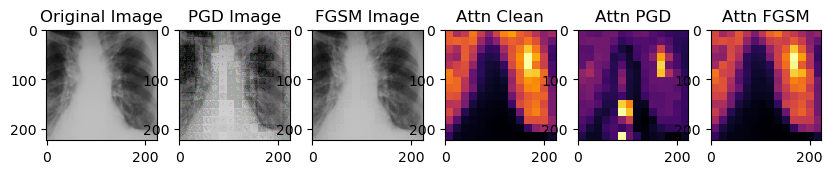

In [133]:
image_folder = "/home/raza.imam/Documents/HC701B/Project/data/TB_data/testing/Tuberculosis/"
image_files = [
        f for f in os.listdir(image_folder) if f.endswith(".jpg") or f.endswith(".png")
    ]

transform = transforms.Compose(
    [
        transforms.Grayscale(num_output_channels=3),
        transforms.RandomRotation((90,90)),
        transforms.CenterCrop(400),
        transforms.Resize((224, 224)),
        # transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.ToTensor(),
    ]
)

image_path = os.path.join(image_folder, image_files[18])
image = Image.open(image_path)
img = transform(image)
img = img.unsqueeze(0)

pgd = PGD(model, lower_bound=0, upper_bound=1)
eps = 0.01
pgd_image = pgd.perturb(img.cuda(), radius=0.13, step_size=eps, step_num=7, target=0) 
pgd_img = torch.tensor((pgd_image.cpu().data.numpy()))

fgsm = FGSM(model, lower_bound=0, upper_bound=1)
eps=0.01
fgsm_image = fgsm.perturb(img.cuda(), epsilon=eps, target=0)
fgsm_img = torch.tensor((fgsm_image.cpu().data.numpy()))

img_attn = get_blk_attn(input_img=img.cuda(), blk=11, model=model)
pgd_img_attn = get_blk_attn(input_img=pgd_img.cuda(), blk=11, model=model)
fgsm_img_attn = get_blk_attn(input_img=fgsm_img.cuda(), blk=11, model=model)

plt.figure(figsize=(10, 10))
text = ["Original Image", "PGD Image", "FGSM Image", "Attn Clean", "Attn PGD", "Attn FGSM"]
for i, fig in enumerate([img.squeeze(0).permute(2,1,0), pgd_img.squeeze(0).permute(2,1,0), fgsm_img.squeeze(0).permute(2,1,0), img_attn, pgd_img_attn, fgsm_img_attn]):
    print(fig.shape)
    plt.subplot(1, 6, i+1)
    plt.imshow(fig, cmap='inferno')
    plt.title(text[i])
plt.show()

/home/raza.imam/.conda/envs/xaim/lib/python3.7/site-packages/captum/_utils/gradient.py:59: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index


12
5


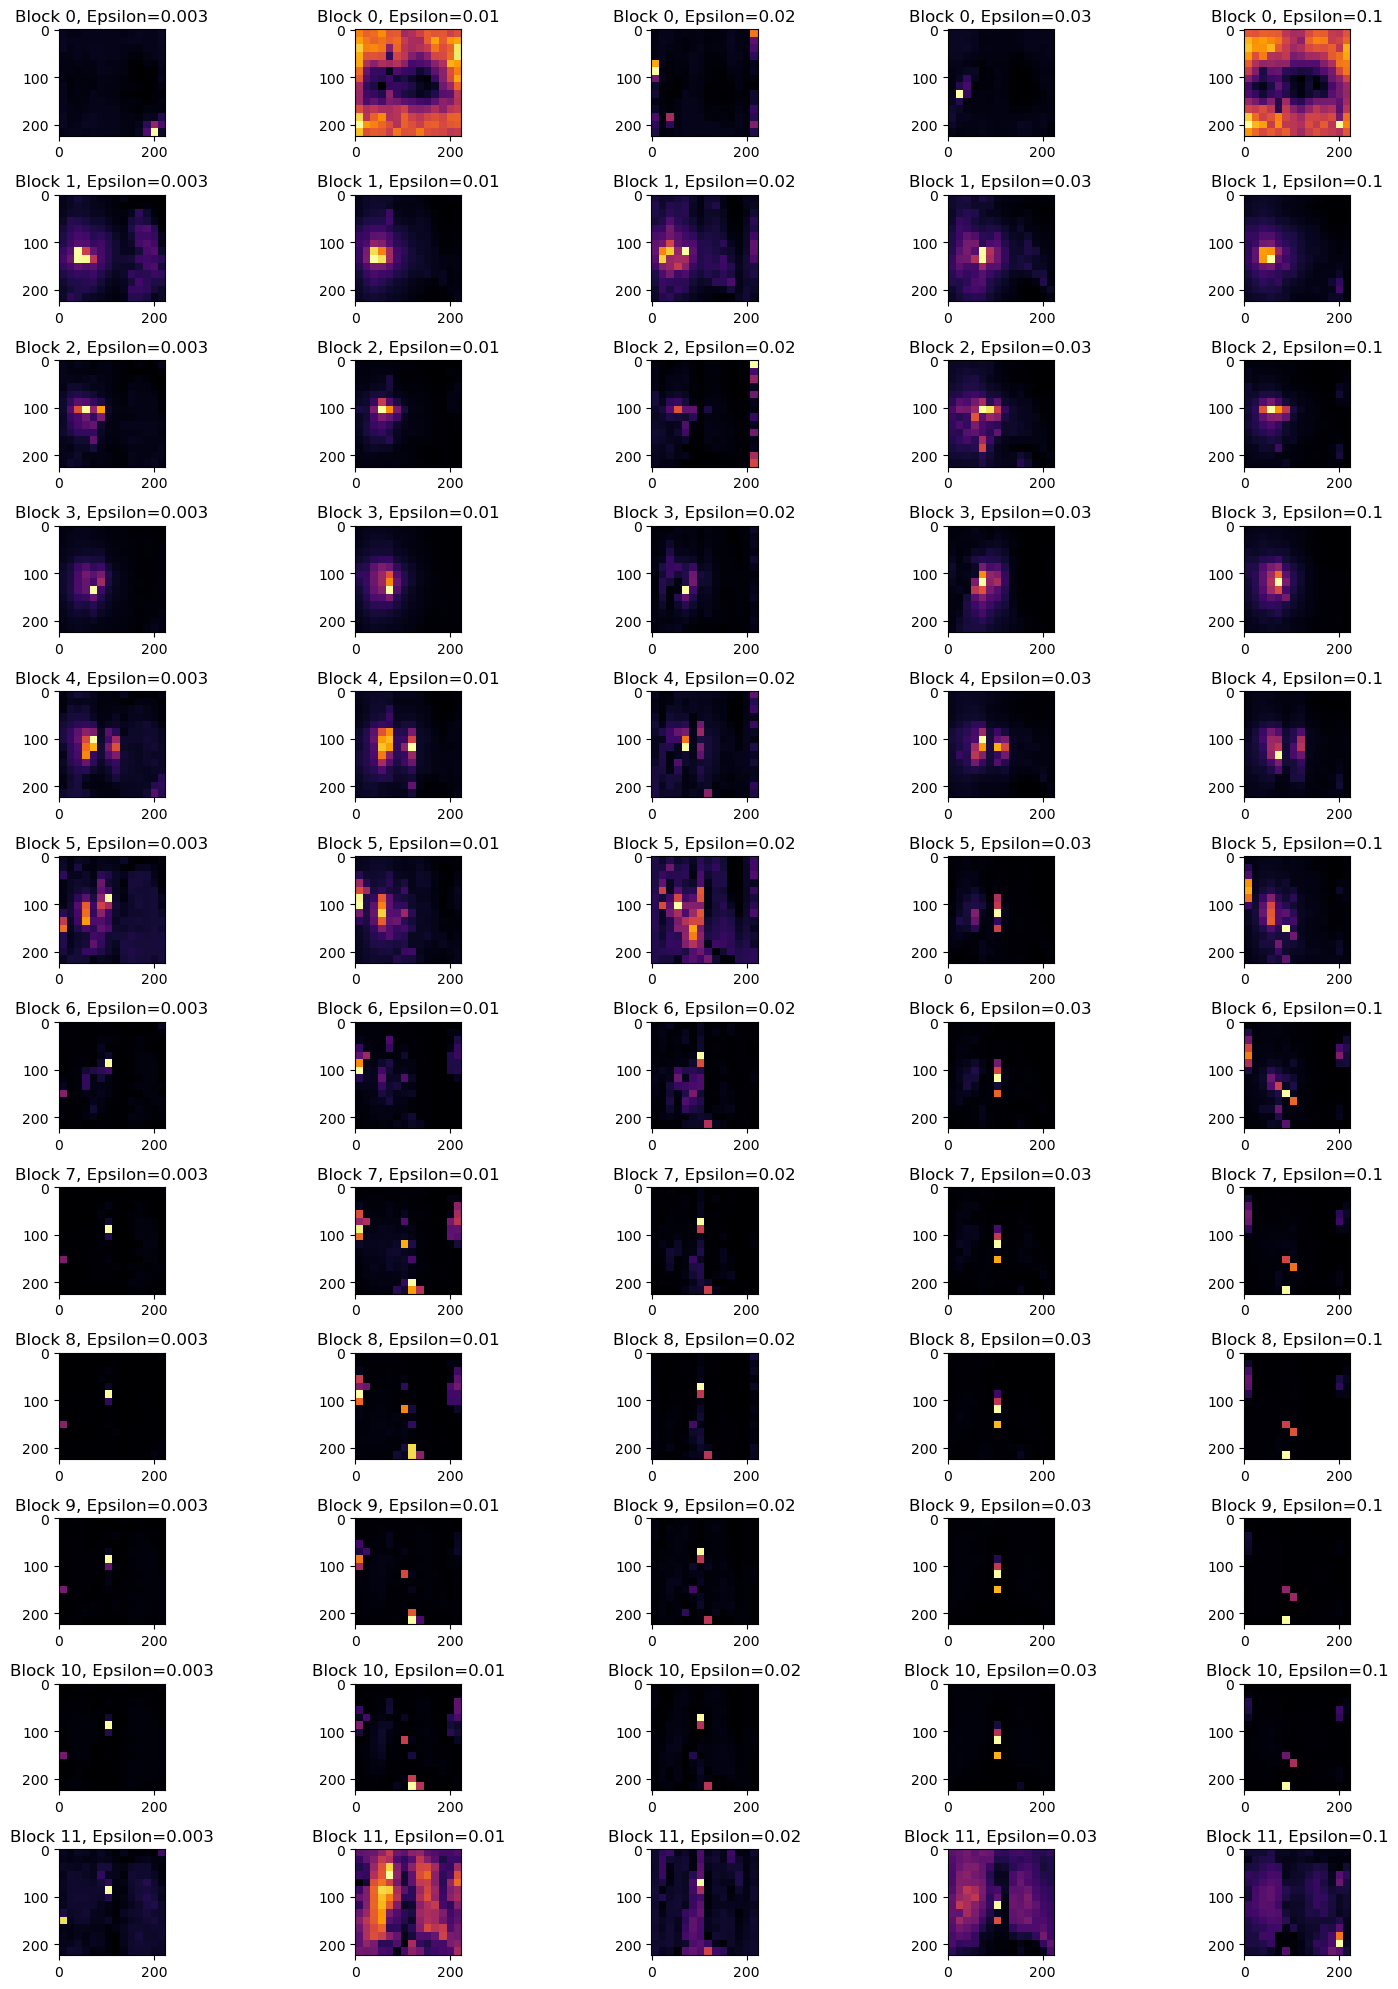

In [137]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
from captum.attr import LayerActivation, LayerGradientXActivation
from captum.attr import visualization as viz
from tqdm import tqdm

# Define the image folder and load the model
image_folder = "/home/raza.imam/Documents/HC701B/Project/data/TB_data/testing/Tuberculosis/"
image_files = [
    f for f in os.listdir(image_folder) if f.endswith(".jpg") or f.endswith(".png")
]

# Define the transformation for image preprocessing
transform = transforms.Compose(
    [
        transforms.Grayscale(num_output_channels=3),
        transforms.RandomRotation((90, 90)),
        transforms.CenterCrop(400),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]
)

# Define the number of images to read (N)
N = 20  # Change this to the desired number of images

# Create an empty list to store the images
images_list = []

# Loop through the first N image files and apply the transformation
for i in range(N):
    image_path = os.path.join(image_folder, image_files[i])
    image = Image.open(image_path)
    img = transform(image)
    img = img.unsqueeze(0)
    images_list.append(img)

# Convert the list of images into a tensor
images_tensor = torch.cat(images_list, dim=0)

# Define epsilon values to iterate over
eps_list = [0.003, 0.01, 0.02, 0.03, 0.1]

# Initialize lists to store average attention maps for each block and epsilon
avg_attentions = [[] for _ in range(12)]

# Loop through the images and epsilon values
for img in images_tensor:
    img = img.unsqueeze(0)

    # Initialize lists to store attention maps for each block and epsilon
    attentions = [[] for _ in range(12)]

    for eps in eps_list:
        pgd = PGD(model, lower_bound=0, upper_bound=1)
        pgd_image = pgd.perturb(img.cuda(), radius=0.13, step_size=eps, step_num=40, target=1)
        pgd_img = torch.tensor((pgd_image.cpu().data.numpy()))

        for block in range(12):
            img_attn = get_blk_attn(input_img=pgd_img.cuda(), blk=block, model=model)
            attentions[block].append(img_attn)

    # Calculate the average attention maps for each block and epsilon
    for block in range(12):
        avg_attention = np.mean(attentions[block], axis=0)
        avg_attentions[block].append(avg_attention)

# Plot the average attention maps
num_blocks = len(avg_attentions)
print(num_blocks)
num_epsilons = len(eps_list)
print(num_epsilons)

plt.figure(figsize=(15, 20))

for block in range(num_blocks):
    for eps_idx, epsilon in enumerate(eps_list):
        plt.subplot(num_blocks, num_epsilons, block * num_epsilons + eps_idx + 1)
        plt.imshow(avg_attentions[block][eps_idx], cmap='inferno')
        plt.title(f'Block {block}, Epsilon={epsilon}')

plt.tight_layout()
plt.show()


/home/raza.imam/.conda/envs/xaim/lib/python3.7/site-packages/captum/_utils/gradient.py:59: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index


12
5


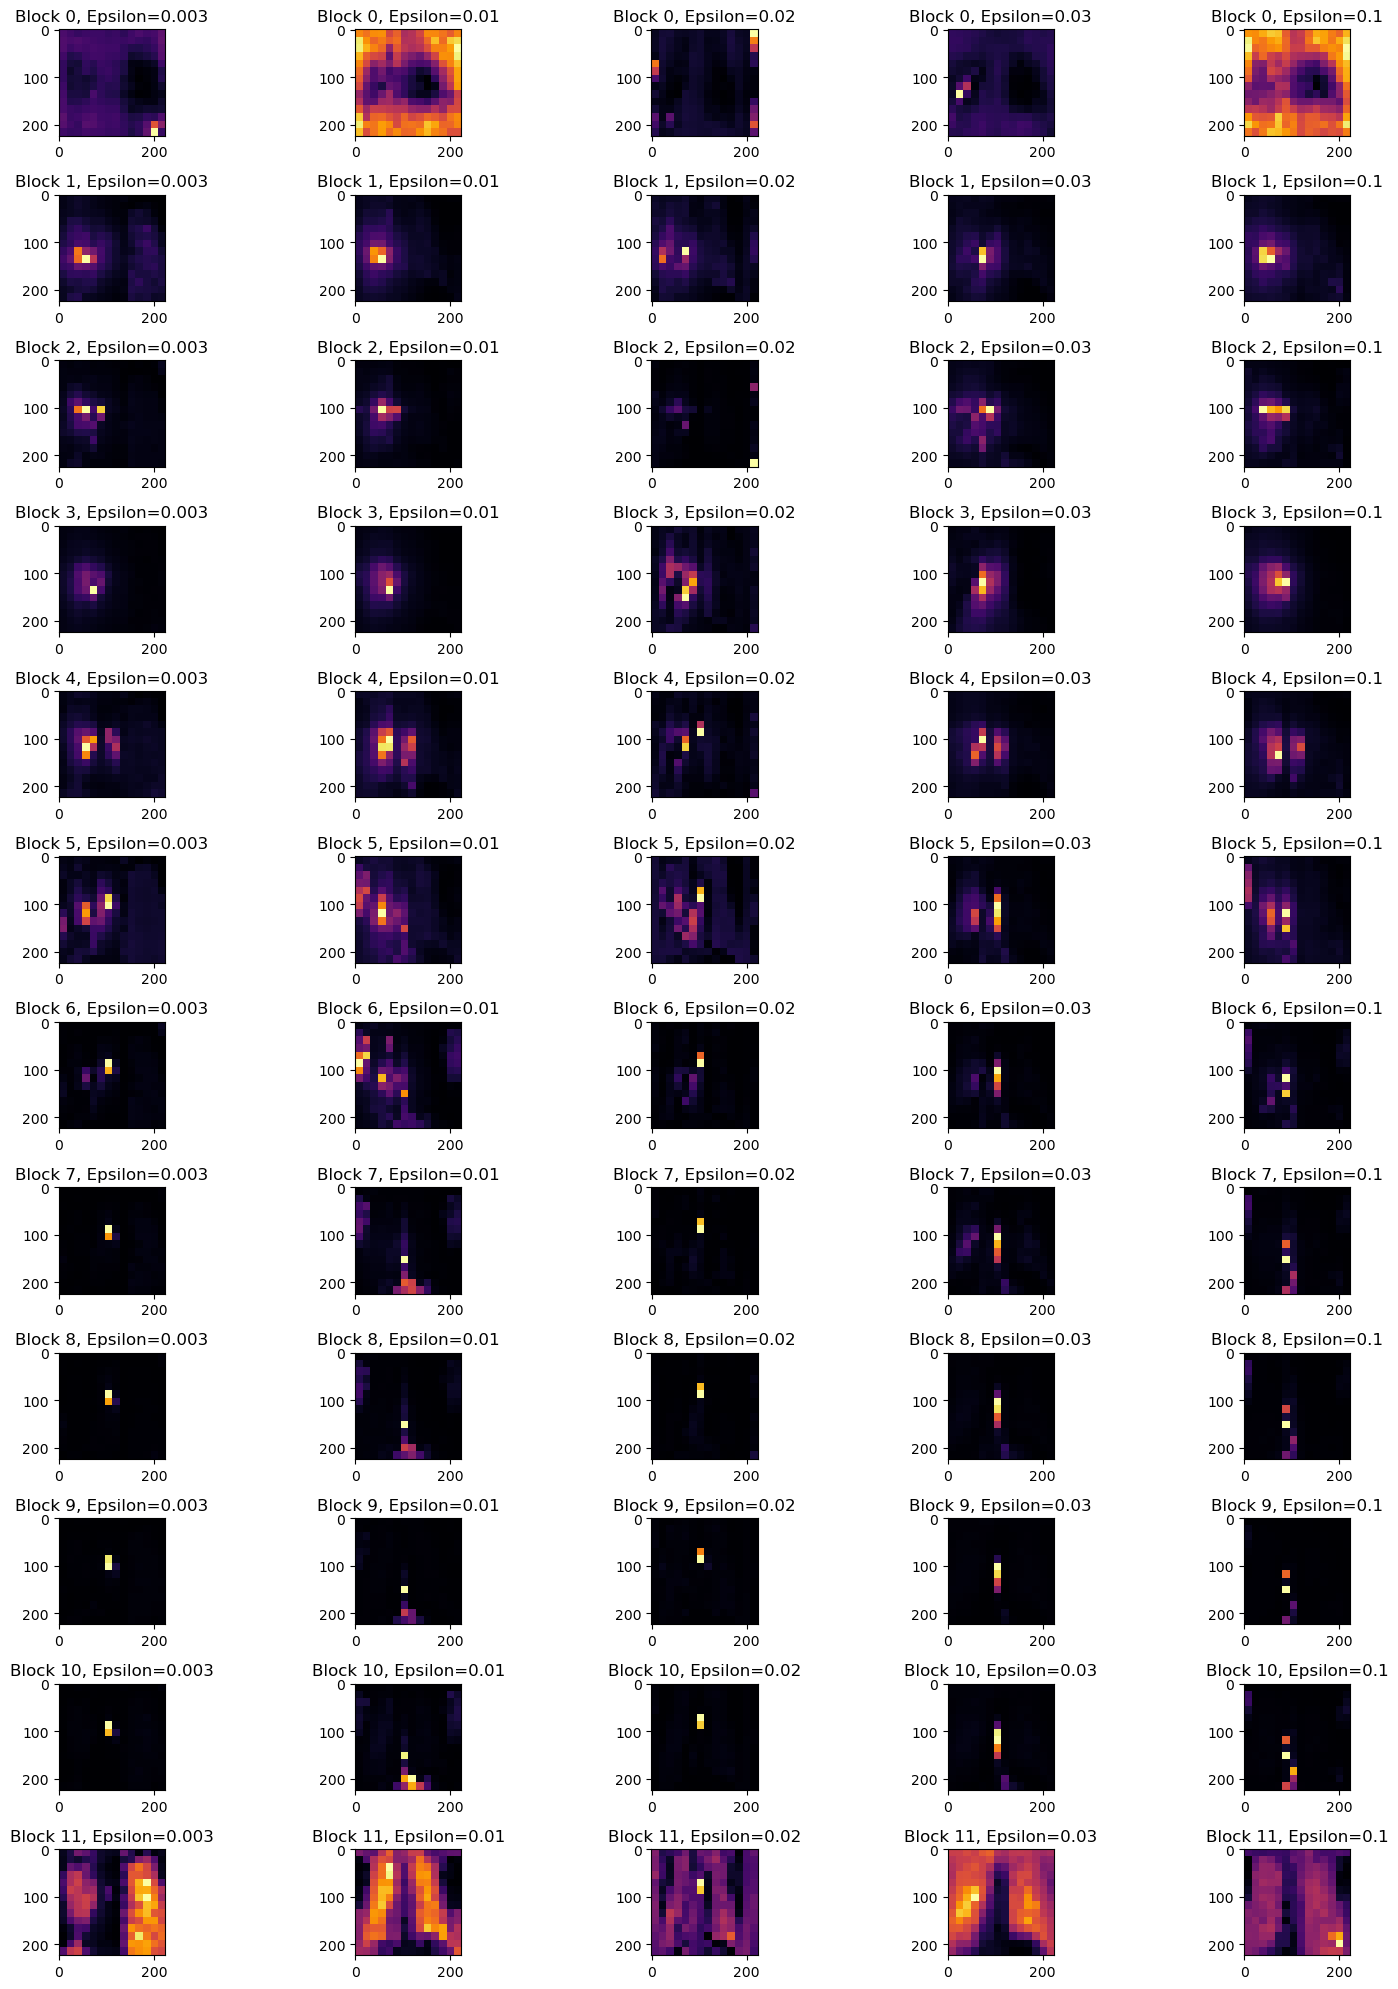

In [139]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
from captum.attr import LayerActivation, LayerGradientXActivation
from captum.attr import visualization as viz
from tqdm import tqdm

# Define the image folder and load the model
image_folder = "/home/raza.imam/Documents/HC701B/Project/data/TB_data/testing/Tuberculosis/"
image_files = [
    f for f in os.listdir(image_folder) if f.endswith(".jpg") or f.endswith(".png")
]

# Define the transformation for image preprocessing
transform = transforms.Compose(
    [
        transforms.Grayscale(num_output_channels=3),
        transforms.RandomRotation((90, 90)),
        transforms.CenterCrop(400),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]
)

# Define the number of images to read (N)
N = 20  # Change this to the desired number of images

# Create an empty list to store the images
images_list = []

# Loop through the first N image files and apply the transformation
for i in range(N):
    image_path = os.path.join(image_folder, image_files[i])
    image = Image.open(image_path)
    img = transform(image)
    img = img.unsqueeze(0)
    images_list.append(img)

# Convert the list of images into a tensor
images_tensor = torch.cat(images_list, dim=0)

# Define epsilon values to iterate over
eps_list = [0.003, 0.01, 0.02, 0.03, 0.1]

# Initialize lists to store average attention maps for each block and epsilon
avg_attentions = [[] for _ in range(12)]

# Loop through the images and epsilon values
for img in images_tensor:
    img = img.unsqueeze(0)

    # Initialize lists to store attention maps for each block and epsilon
    attentions = [[] for _ in range(12)]

    for eps in eps_list:
        fgsm = FGSM(model, lower_bound=0, upper_bound=1)
        fgsm_image = fgsm.perturb(img.cuda(), epsilon=eps, target=1)
        fgsm_img = torch.tensor((fgsm_image.cpu().data.numpy()))

        for block in range(12):
            img_attn = get_blk_attn(input_img=fgsm_img.cuda(), blk=block, model=model)
            attentions[block].append(img_attn)

    # Calculate the average attention maps for each block and epsilon
    for block in range(12):
        avg_attention = np.mean(attentions[block], axis=0)
        avg_attentions[block].append(avg_attention)

# Plot the average attention maps
num_blocks = len(avg_attentions)
print(num_blocks)
num_epsilons = len(eps_list)
print(num_epsilons)

plt.figure(figsize=(15, 20))

for block in range(num_blocks):
    for eps_idx, epsilon in enumerate(eps_list):
        plt.subplot(num_blocks, num_epsilons, block * num_epsilons + eps_idx + 1)
        plt.imshow(avg_attentions[block][eps_idx], cmap='inferno')
        plt.title(f'Block {block}, Epsilon={epsilon}')

plt.tight_layout()
plt.show()


# 1. Generate (test) samples

In [19]:
image_folder = "/home/raza.imam/Documents/HC701B/Project/data/TB_data/testing/Tuberculosis/"

image_files = [f for f in os.listdir(image_folder) if f.endswith(".jpg") or f.endswith(".png")]
image_files = random.sample(image_files, 20)
all_imgs = []
all_attns = []
all_attn_diff = []

for img_name in image_files:
    img, attns, attn_diff = test_img_attn(
        image_folder=image_folder, 
        block=11, 
        model = model, 
        img_name=img_name, # tested image
        plot=False, 
        # rand=False, 
        # random_state=0,
        attack_type=['PGD'], 
        eps=0.03, 
        device=device
        )
    all_imgs.append(img)        
    all_attns.append(attns)
    all_attn_diff.append(attn_diff)
    
# For FGSM
# attns_cln = [] #list of n test attentions
# attns_fgsm = []
# attack = "FGSM"
# for i in range(n_test_attns):
#     img, attn_cln, attn_adv, att_diff = test_img_attn(image_folder, block, model, plot=plot, rand=rand, random_state=random_state,
#                                                       attack_type=attack, eps=eps, device=device)
#     attns_cln.append(attn_cln)
#     attns_fgsm.append(attn_adv)

 Attacking images with ['PGD']
Foolbox


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


 Attacking images with ['PGD']
Foolbox


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


 Attacking images with ['PGD']
Foolbox


100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


 Attacking images with ['PGD']
Foolbox


100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


 Attacking images with ['PGD']
Foolbox


100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


 Attacking images with ['PGD']
Foolbox


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


 Attacking images with ['PGD']
Foolbox


100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


 Attacking images with ['PGD']
Foolbox


100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


 Attacking images with ['PGD']
Foolbox


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


 Attacking images with ['PGD']
Foolbox


100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


 Attacking images with ['PGD']
Foolbox


100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


 Attacking images with ['PGD']
Foolbox


100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


 Attacking images with ['PGD']
Foolbox


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


 Attacking images with ['PGD']
Foolbox


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


 Attacking images with ['PGD']
Foolbox


100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


 Attacking images with ['PGD']
Foolbox


100%|██████████| 1/1 [00:01<00:00,  1.00s/it]


 Attacking images with ['PGD']
Foolbox


100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


 Attacking images with ['PGD']
Foolbox


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


 Attacking images with ['PGD']
Foolbox


100%|██████████| 1/1 [00:01<00:00,  1.00s/it]


 Attacking images with ['PGD']
Foolbox


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


In [33]:
attns_cln = []
attns_adv = []
for i in range(len(all_attns)):
    attns_cln.append(all_attns[i]['clean'])
    attns_adv.append(all_attns[i]['PGD'])
    
print(len(attns_cln), len(attns_adv))

20 20


In [20]:
np.sum(all_attns[0]['clean']), np.sum(all_attns[0]['PGD'])

(245.52678, 245.22997)

torch.Size([224, 224, 3])
(224, 224)
(224, 224)


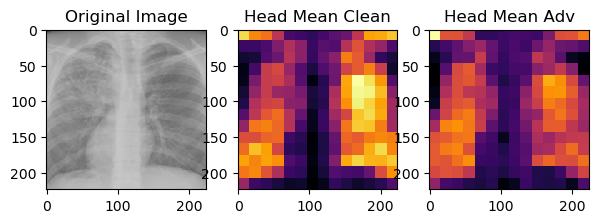

In [22]:
plt.figure(figsize=(7, 7))
text = ["Original Image", "Head Mean Clean", "Head Mean Adv"]
img_no = 0
for i, fig in enumerate([all_imgs[img_no].squeeze(0).permute(2,1,0), all_attns[img_no]['clean'], all_attns[img_no]['PGD']]):
    print(fig.shape)
    plt.subplot(1, 3, i+1)
    plt.imshow(fig, cmap='inferno')
    plt.title(text[i])
plt.show()

# 2. Mean Attention of a block. For 2000 (train) images. 

In [9]:
from saliency import mean_attns_N_images
image_folder = "/home/raza.imam/Documents/HC701B/Project/data/TB_data/training/Tuberculosis/"
block = 11 #Select range from 0 to 11
N_images = 100
N_random = False
device = "cuda"

print(f"On Block {block}")
all_attns, mean_attns, mean_attn_diff = mean_attns_N_images(image_folder=image_folder, n_images=N_images, 
                                                                      block=block, model=model, n_random=N_random, device=device, attack_type="PGD", eps=0.02)

On Block 11
cuda
Foolbox


100%|██████████| 100/100 [01:43<00:00,  1.03s/it]


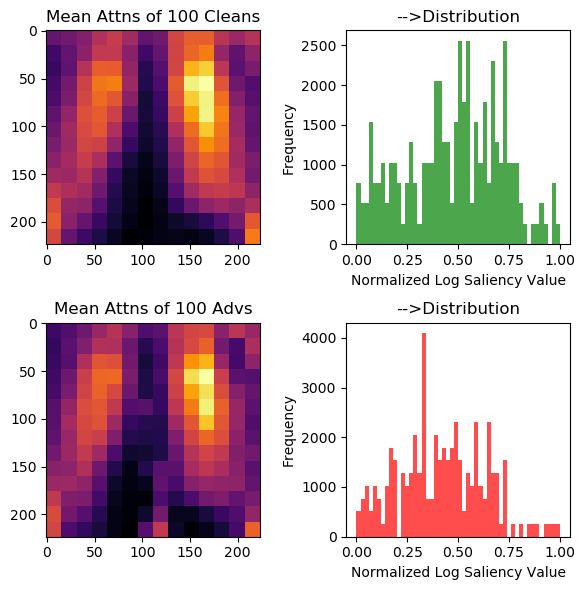

In [24]:
mean_attns_cln, mean_attns_adv, = mean_attns['clean'], mean_attns['PGD']

hist_plot(mean_attns_cln, mean_attns_adv, N_images)

In [23]:
np.mean(mean_attns_cln), np.mean(mean_attns_adv)

(0.004944364, 0.0049412893)

# 3. Compare test sample attn with mean clean and adv attns

In [25]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
# Defining function
def classify_image_cos_similarity(test_attn, mean_attns_cln, mean_attns_adv): #np.dot(test_image,normal_image)/(norm(test_image)*norm(normal_image))
    # Flatten the images to 1D arrays (if not already flattened)
    test_attn_flat = test_attn.flatten()
    mean_attns_cln_flat = mean_attns_cln.flatten()
    mean_attns_adv_flat = mean_attns_adv.flatten()
    # Calculate cosine similarities
    similarity_to_normal = cosine_similarity([test_attn_flat], [mean_attns_cln_flat])
    similarity_to_adversarial = cosine_similarity([test_attn_flat], [mean_attns_adv_flat])

    print(f"similarity_to_normal: {similarity_to_normal}", f"similarity_to_adversarial: {similarity_to_adversarial}")
    # Compare similarity scores and classify
    if similarity_to_normal > similarity_to_adversarial:
        return "Clean"
    else:
        return "Adversarial"

#__main__
# result = classify_image_cos_similarity(attns_cln[4], mean_attns_cln, mean_attns_adv)
# print(f"Test image is classified as: {result}")


In [26]:
import numpy as np
from scipy.spatial.distance import euclidean
# Defining function
def classify_image_euclidean(test_attn, mean_attns_cln, mean_attns_adv): # np.sqrt(np.sum(np.square(test_attn - mean_attns_cln)))
    # Flatten the images to 1D arrays (if not already flattened)
    test_attn_flat = test_attn.flatten()
    mean_attns_cln_flat = mean_attns_cln.flatten()
    mean_attns_adv_flat = mean_attns_adv.flatten()
    # Calculate Euclidean distances
    distance_to_normal = euclidean(test_attn_flat, mean_attns_cln_flat)
    distance_to_adversarial = euclidean(test_attn_flat, mean_attns_adv_flat)
    
    print(f"distance_to_normal: {distance_to_normal}", f"distance_to_adversarial: {distance_to_adversarial}")
    # Compare distances and classify
    if distance_to_normal < distance_to_adversarial:
        return "Clean"
    else:
        return "Adversarial"

#__main__
# result = classify_image_euclidean(attns_cln[4], mean_attns_cln, mean_attns_adv)
# print(f"Test image is classified as: {result}")

In [27]:
def classify_image_sum(test_attn, mean_attns_cln, mean_attns_adv): #np.sum((test_attn - mean_attns_cln)) #FIXME:
    # Flatten the images to 1D arrays (if not already flattened)
    test_attn_flat = test_attn.flatten()
    mean_attns_cln_flat = mean_attns_cln.flatten()
    mean_attns_adv_flat = mean_attns_adv.flatten()
    # Calculate cosine similarities
    distance_to_normal = np.sum((test_attn_flat - mean_attns_cln_flat))
    distance_to_adversarial = np.sum((test_attn_flat - mean_attns_adv_flat))

    print(f"distance_to_normal: {distance_to_normal}", f"distance_to_adversarial: {distance_to_adversarial}")
    # Compare distances and classify
    if distance_to_normal < distance_to_adversarial:
        return "Clean"
    else:
        return "Adversarial"
    
#__main__
# result = classify_image_sum(attns_adv[4], mean_attns_cln, mean_attns_adv)
# print(f"Test image is classified as: {result}")

In [40]:
from skimage.metrics import structural_similarity as ssim

def classify_image_ssim(test_image, clean_image, adversarial_image, threshold=0.9):
    # Calculate SSIM between test image and clean image
    ssim_clean = ssim(test_image, clean_image, data_range=test_image.max() - test_image.min())

    # Calculate SSIM between test image and adversarial image
    ssim_adv = ssim(test_image, adversarial_image, data_range=test_image.max() - test_image.min())

    print(f"SSIM to Clean: {ssim_clean}, SSIM to Adversarial: {ssim_adv}")

    # Compare SSIM values and classify
    if ssim_clean > ssim_adv:
        return "Clean"
    else:
        return "Adversarial"
    
#__main__
result = classify_image_ssim(attns_cln[4], mean_attns_cln, mean_attns_adv)
print(f"Test image is classified as: {result}")

SSIM to Clean: 0.7223774987778828, SSIM to Adversarial: 0.7001132035646789
Test image is classified as: Clean


In [44]:
num_test_images = len(attns_cln)
test_attns = attns_cln

classifications = []
# Test each test image
for test_attn in test_attns:
    result = classify_image_ssim(test_attn, mean_attns_cln, mean_attns_adv)
    classifications.append(result)

# Calculate accuracy
true_labels = ["Clean"] * num_test_images  # Assuming all test images should be classified as "Normal"
accuracy = sum(1 for true, predicted in zip(true_labels, classifications) if true == predicted) / num_test_images
print(f"Overall Accuracy: {accuracy * 100:.2f}%")


SSIM to Clean: 0.7369680056285205, SSIM to Adversarial: 0.6893014188561527
SSIM to Clean: 0.8136625469656638, SSIM to Adversarial: 0.7455294921765511
SSIM to Clean: 0.6123383483423165, SSIM to Adversarial: 0.628098783899049
SSIM to Clean: 0.6066406823217249, SSIM to Adversarial: 0.5831420577075945
SSIM to Clean: 0.7223774987778828, SSIM to Adversarial: 0.7001132035646789
SSIM to Clean: 0.7250476044147816, SSIM to Adversarial: 0.6932871537008468
SSIM to Clean: 0.6169753440605216, SSIM to Adversarial: 0.6060862507081497
SSIM to Clean: 0.6679324135869255, SSIM to Adversarial: 0.6643699791845529
SSIM to Clean: 0.6681268026857975, SSIM to Adversarial: 0.6855910446812578
SSIM to Clean: 0.6961096214053332, SSIM to Adversarial: 0.671068467912053
SSIM to Clean: 0.7457413448835529, SSIM to Adversarial: 0.7461964296561966
SSIM to Clean: 0.770099868402051, SSIM to Adversarial: 0.7178255067630368
SSIM to Clean: 0.692246117563204, SSIM to Adversarial: 0.6694788183403163
SSIM to Clean: 0.654526556987